In [91]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 

In [92]:
# Read Train and Test dataset
data_train = pd.read_csv("./nsl-kdd/KDDTrain+.txt")

In [93]:
# Check data
data_train.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.18,2,2.1,0.00,0.00.1,0.00.2,0.00.3,1.00,0.00.4,0.00.5,150,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [94]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

In [95]:
# Assign name for columns
data_train.columns = columns

In [96]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [97]:
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [98]:
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

In [99]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

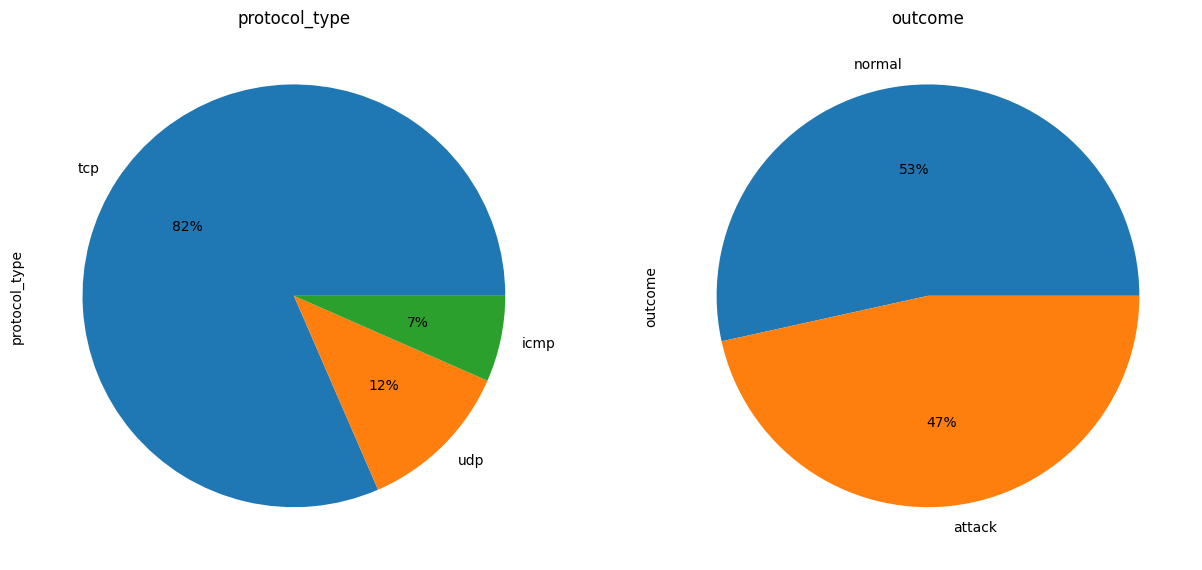

In [100]:
pie_plot(data_train, ['protocol_type', 'outcome'], 1, 2)

In [101]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [102]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [103]:
scaled_train = preprocess(data_train)

In [104]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


In [105]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy GaussianNB 91.80269307480874  Test Accuracy GaussianNB 91.60547727723754
Training Precesion GaussianNB 92.62657528189256  Test Precesion GaussianNB 92.53246753246754
Training Recall GaussianNB 89.47907990004485  Test Recall GaussianNB 89.29629943263613


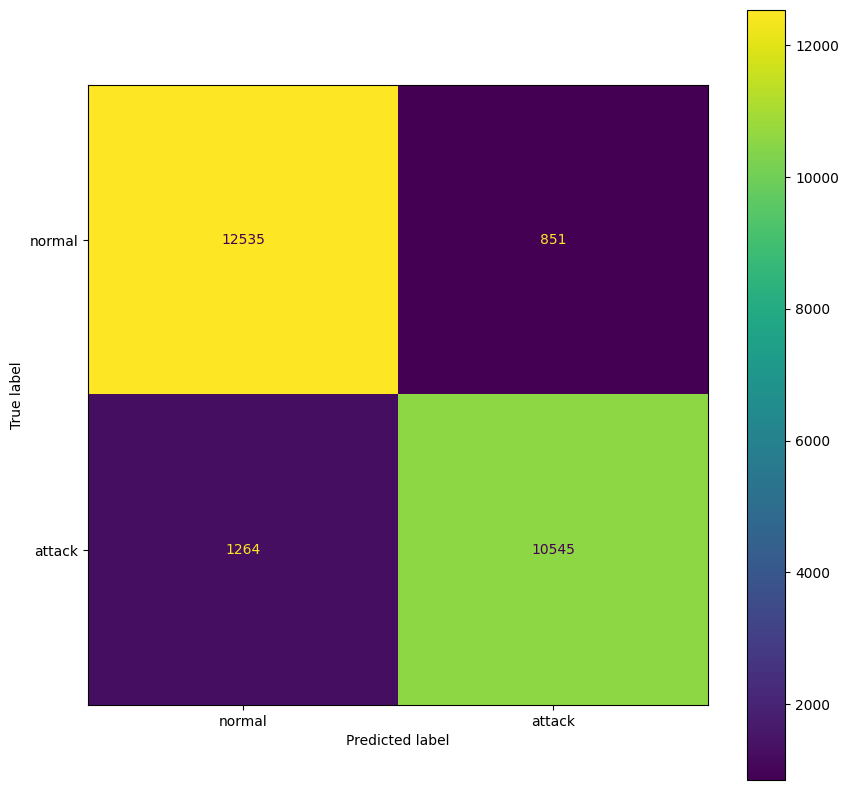

In [106]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

In [107]:
# Predict probabilities on the test set
y_pred_prob_gnb = gnb.predict_proba(x_test)[:, 1]

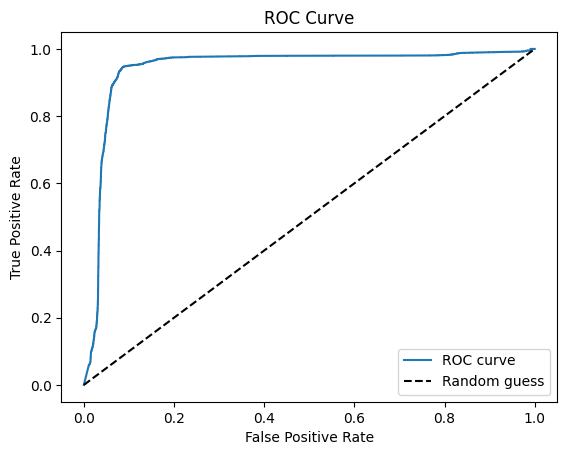

In [108]:
# Compute false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_gnb)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [109]:
xg_r = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 20).fit(x_train_reg, y_train_reg)

[18:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [110]:
name = "XGBOOST"
train_error = metrics.mean_squared_error(y_train_reg, xg_r.predict(x_train_reg), squared=False)
test_error = metrics.mean_squared_error(y_test_reg, xg_r.predict(x_test_reg), squared=False)
print("Training Error " + str(name) + " {}  Test error ".format(train_error) + str(name) + " {}".format(test_error))

Training Error XGBOOST 0.9549338655457729  Test error XGBOOST 1.0322196273094075


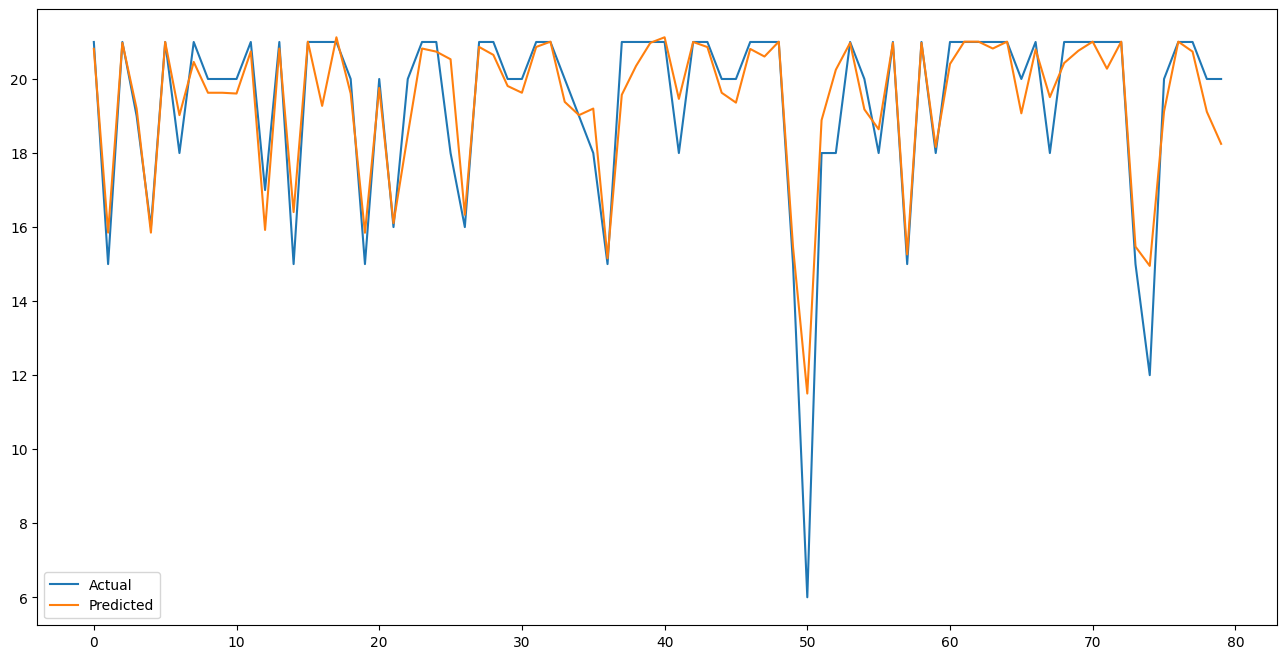

In [111]:
y_pred = xg_r.predict(x_test_reg)
df = pd.DataFrame({"Y_test": y_test_reg , "Y_pred" : y_pred})
plt.figure(figsize=(16,8))
plt.plot(df[:80])
plt.legend(['Actual' , 'Predicted'])

In [112]:
# predict the probabilities for the test data
y_pred_xg_r = xg_r.predict(x_test)

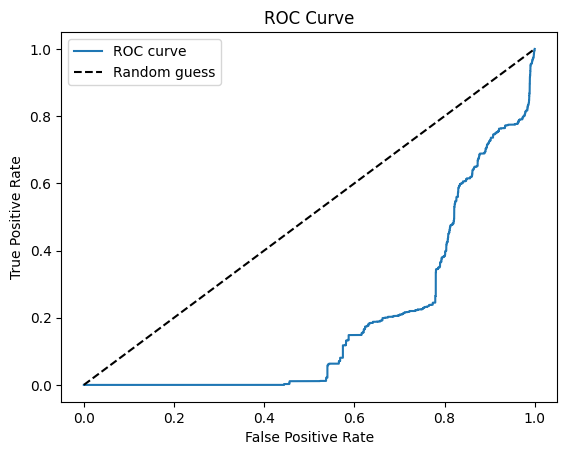

In [113]:
# Compute false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_xg_r)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [114]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(122,), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])


In [115]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                7872      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               66048     
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 128)              

In [117]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [118]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, verbose=1)

Epoch 1/10
3150/3150 [==============================] - 14s 4ms/step - loss: 1755.3260 - accuracy: 0.9600 - val_loss: 1517.0460 - val_accuracy: 0.9754
Epoch 2/10
3150/3150 [==============================] - 12s 4ms/step - loss: 416.3802 - accuracy: 0.9731 - val_loss: 466.4740 - val_accuracy: 0.9778
Epoch 3/10
3150/3150 [==============================] - 12s 4ms/step - loss: 143.6042 - accuracy: 0.9757 - val_loss: 99.8260 - val_accuracy: 0.9854
Epoch 4/10
3150/3150 [==============================] - 12s 4ms/step - loss: 15.0221 - accuracy: 0.9803 - val_loss: 0.1113 - val_accuracy: 0.9888
Epoch 5/10
3150/3150 [==============================] - 12s 4ms/step - loss: 0.2063 - accuracy: 0.9791 - val_loss: 0.3460 - val_accuracy: 0.9843
Epoch 6/10
3150/3150 [==============================] - 12s 4ms/step - loss: 0.1804 - accuracy: 0.9793 - val_loss: 0.3031 - val_accuracy: 0.9841
Epoch 7/10
3150/3150 [==============================] - 12s 4ms/step - loss: 0.1927 - accuracy: 0.9755 - val_loss: 6

In [119]:
# Make predictions on test data using deep learning model
y_pred_ann = model.predict(x_test)

788/788 [==============================] - 1s 1ms/step


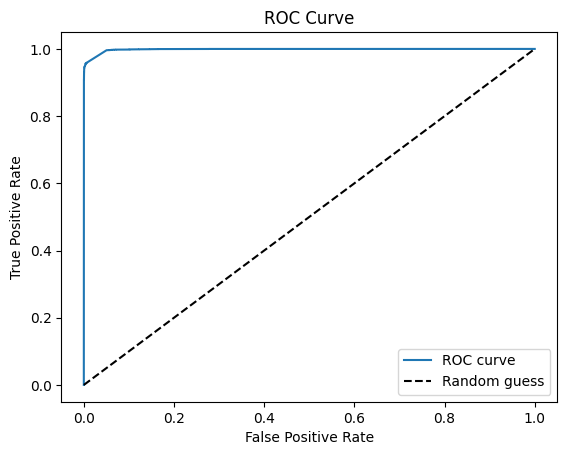

In [120]:
# Compute false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_ann)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [122]:
model.save('my_model.h5')